### Содержание:
* [Подключение библиотек и скриптов](#first-bullet)
* [Загрузка данных](#2s-bullet)
* [Приведение типов](#3s-bullet)
* [Обзор данных](#4s-bullet)
* [Обработка выбросов](#5s-bullet)
* [Обработка пропусков](#6s-bullet)
* [Построение новых признаков](#7s-bullet)
* [Отбор признаков](#8s-bullet)
* [Разбиение на train и test](#9s-bullet)
* [Построение модели](#10s-bullet)


### Подключение библиотек и скриптов <a class="anchor" id="first-bullet"></a>

In [96]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [97]:
import warnings
warnings.filterwarnings('ignore')

In [98]:
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [99]:
TRAIN_DATASET_PATH = './data/project_task/train.csv' # y_train, y_valid
TEST_DATASET_PATH = './data/project_task/test.csv'

### Загрузка данных  <a class="anchor" id="2s-bullet"></a>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [100]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
#train_df.tail()

In [101]:
test_df = pd.read_csv(TEST_DATASET_PATH)
#test_df.tail()

### Приведение типов <a class="anchor" id="3s-bullet"></a>

In [102]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [103]:
train_df.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

In [104]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### Обзор данных <a class="anchor" id="4s-bullet"></a>

**Целевая переменная**

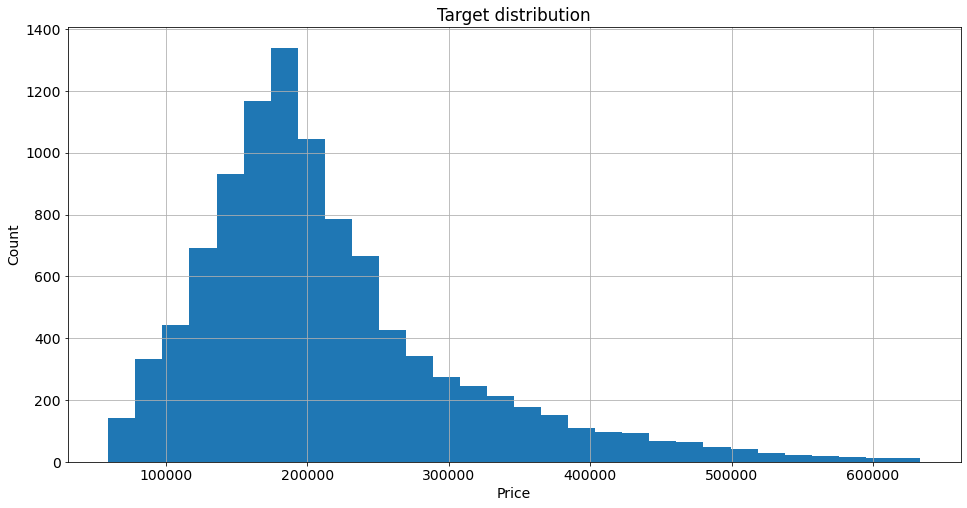

In [105]:
plt.figure(figsize = (16, 8))
train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [106]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Категориальные переменные**

In [107]:
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

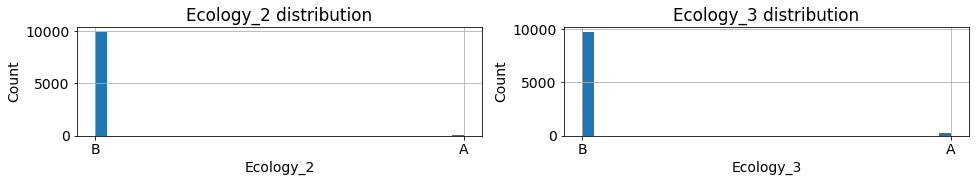

In [108]:
plt.figure(figsize = (16, 2))

plt.subplot (1, 2, 1)
train_df['Ecology_2'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Ecology_2')
plt.title('Ecology_2 distribution')

plt.subplot (1, 2, 2)
train_df['Ecology_3'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Ecology_3')
plt.title('Ecology_3 distribution')

plt.show()

<i> Кажется, Ecology_2 и Ecology_3 ни на что не влияют, просто не буду их включать в модель

In [109]:
train_df['Shops_2'].describe()

count     10000
unique        2
top           B
freq       9175
Name: Shops_2, dtype: object

<i> а в Shops_2 8,25% приходится на значение "A", необходимо дополнительное исследование...

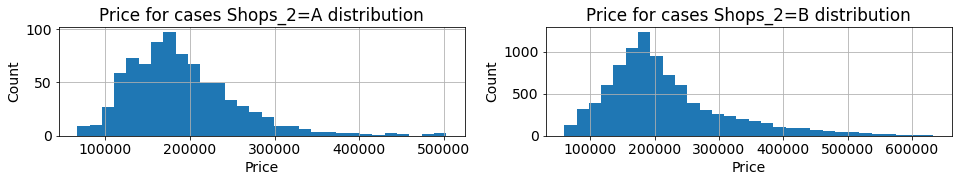

In [110]:
plt.figure(figsize = (16, 2))

plt.subplot (1, 2, 1)
train_df[train_df.Shops_2=='A'].Price.hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Price for cases Shops_2=A distribution')

plt.subplot (1, 2, 2)
train_df[train_df.Shops_2=='B'].Price.hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Price for cases Shops_2=B distribution')

plt.show()


<i> Распределения цены похожи для значений А и B, значит признак Shop_2 слабо влияет на результат - тоже из модели исключаем

### Обработка выбросов  <a class="anchor" id="5s-bullet"></a>

**Rooms**

In [111]:
train_df['Rooms'].value_counts().sort_index()

0.0        8
1.0     3705
2.0     3880
3.0     2235
4.0      150
5.0       18
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

In [112]:
# Смотрим средние цены в "основном" и "подозрительных" диапазонах по числу комнат
print(train_df[train_df.Rooms.between(0, 1)].Price.median())
print(train_df[train_df.Rooms.between(1, 6)].Price.median())
print(train_df[train_df.Rooms.between(5, 7)].Price.median())
print(train_df[train_df.Rooms.between(7, 20)].Price.median())

# Похоже, что 0, 10, 19 - выбросы

155012.2077213257
192261.9632697044
455264.8826664848
172329.270863477


In [113]:
train_df.loc[(train_df['Rooms'] > 6) | (train_df['Rooms'] < 1), 'Rooms'] = train_df['Rooms'].median()

**Square, LifeSquare, KitchenSquare**

In [114]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.812096,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [115]:
# Заполняем пропуски 'LifeSquare'
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()


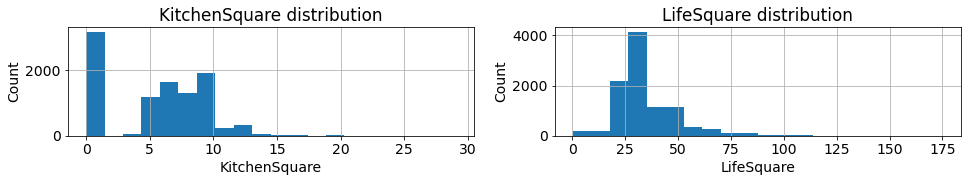

In [116]:
plt.figure(figsize = (16, 2))

plt.subplot (1, 2, 1)
train_df[train_df.KitchenSquare < 30].KitchenSquare.hist(bins=20)
plt.ylabel('Count')
plt.xlabel('KitchenSquare')
plt.title('KitchenSquare distribution')

plt.subplot (1, 2, 2)
train_df[train_df.LifeSquare < 200].LifeSquare.hist(bins=20)
plt.ylabel('Count')
plt.xlabel('LifeSquare')
plt.title('LifeSquare distribution')

plt.show()

In [117]:
# Данные по кухням и жилой площади очень плохие, выкидывать их не хочется - заменяем
# "хвосты" распределений на средние (или минимальные) значения
train_df.loc[(train_df['KitchenSquare'] < 3) | (train_df["KitchenSquare"] > 15), 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[ (train_df['LifeSquare'] < 10),'LifeSquare'] = 10
train_df.loc[ (train_df['LifeSquare'] > 130),'LifeSquare'] = train_df.LifeSquare.median()

train_df.loc[ (train_df['Square'] < 10),'Square'] = 10
train_df.loc[ (train_df['Square'] > 160),'Square'] = train_df.Square.median()
mask = train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare']
train_df[mask].Square = train_df[mask].LifeSquare + train_df[mask].KitchenSquare

**HouseFloor, Floor**

In [118]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [119]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [120]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = int(train_df['HouseFloor'].median())

In [121]:
np.random.seed(27)
floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index
print(len(floor_outliers))

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(
    lambda x: random.randint(1, x)
)

1610


**HouseYear**

In [122]:
train_df['HouseYear'].value_counts().sort_index()

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

In [123]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### Обработка пропусков <a class="anchor" id="6s-bullet"></a>

In [124]:
len(train_df) - train_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

**Healthcare_1**

In [125]:
train_df['Healthcare_1'].head()

0       NaN
1    1183.0
2     240.0
3       NaN
4       NaN
Name: Healthcare_1, dtype: float64

In [126]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

### Построение новых признаков <a class="anchor" id="7s-bullet"></a>

**DistrictSize, IsDistrictLarge**

In [127]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
train_df = train_df.merge(district_size, on='DistrictId', how='left')
#train_df['DistrictSize'].describe()
train_df.loc[(train_df['DistrictSize'] <= 60), 'IsDistrictLarge'] = 0
train_df.loc[(train_df['DistrictSize'] > 60), 'IsDistrictLarge'] = 1
train_df.loc[(train_df['DistrictSize'] > 105), 'IsDistrictLarge'] = 2
train_df.loc[(train_df['DistrictSize'] > 500), 'IsDistrictLarge'] = 3
#train_df['IsDistrictLarge'].head()

**MedPriceByDistrict**

In [128]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

### Отбор признаков <a class="anchor" id="8s-bullet"></a>

In [129]:
#train_df.columns.tolist()

In [130]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                'Healthcare_1', 'Helthcare_2', 'Shops_1']

new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

In [131]:
train_df.shape

(10000, 23)

In [132]:
test_df.shape

(5000, 19)

### Разбиение на train и test <a class="anchor" id="9s-bullet"></a>

In [133]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [134]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, shuffle=True, random_state=21
)

### Построение модели <a class="anchor" id="10s-bullet"></a>

**Обучение и оценка модели**

In [135]:
rf_model = RandomForestRegressor(
    max_depth=8, min_samples_split=20, n_estimators=500, n_jobs=-1, random_state=17
)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_split=20, n_estimators=500,
                      n_jobs=-1, random_state=17)

**Отложенная выборка**

In [136]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

print(r2(y_train, y_train_preds))
print(r2(y_test, y_test_preds))


0.8219996286157857
0.7311079650729659


**Перекрёстная проверка**

In [137]:
cv_score = cross_val_score(
    rf_model,
    X.fillna(-9999),
    y, scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

array([0.74035938, 0.72604519, 0.72507143, 0.74413549, 0.76778428])

In [138]:
cv_score.mean(), cv_score.std()

(0.7406791533437851, 0.015520892485407464)

In [139]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.7251582608583776, 0.7562000458291925)

**Важность признаков**

In [140]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
15,MedPriceByDistrict,0.760519
1,Square,0.109968
10,Social_3,0.019071
3,KitchenSquare,0.015148
6,HouseYear,0.013688
5,HouseFloor,0.013496
8,Social_1,0.011910
2,LifeSquare,0.010629
9,Social_2,0.010369
11,Healthcare_1,0.007754


## Формирование файла с прогнозами

In [141]:
# Не успел написать интерфейс для переключения с учебных данных на реальные, поэтому
# для получения predictions_.csv просто подсовывал модели test_df вместо train_df
#test_id = test_df["Id"]
#pred_df = pd.DataFrame()
#pred_df["Id"] = test_id
#pred_df["Price"] = y_test_preds
#assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

#pred_df.to_csv("./predictions_.csv", index=False)

In [142]:
#pred_df = pd.read_csv("./predictions_.csv")
#pred_df.head(12)

In [143]:
#test_df.shape[0]